In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

Preprocessing - MinMax Normalization and Segmentation

In [54]:
def normalize_data(data, min_value=-1, max_value=1):
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    normalized_data = (data - data_min) / (data_max - data_min)  
    normalized_data = normalized_data * (max_value - min_value) + min_value
    return normalized_data


In [55]:
def segment_data(data, window_size, overlap):
    step = int(window_size * (1 - overlap))
    segments = []
    labels = []

    for start in range(0, len(data) - window_size + 1, step):
        end = start + window_size
        segment = data[start:end, :-1]
        label = data[start:end, -1]
        segments.append(segment)
        labels.append(label[0])
    return np.array(segments), np.array(labels)

In [56]:
data = pd.read_csv(r'D:\Thesis\Example_accelerometer\dataset\combined_dataset.csv')

In [57]:
data

,accx,accy,accz,label
0,80,272,16752,0
1,64,16,16512,0
2,112,304,16512,0
3,-80,304,16752,0
4,-128,288,16560,0
...,...,...,...,...
2043,-624,960,16272,1
2044,-1056,960,16128,1
2045,-1168,1184,15584,1
2046,-1296,1104,13984,1


In [58]:
print(data.isnull().sum())
print(np.isinf(data[['accx', 'accy', 'accz']].values).sum()) 

accx     0
accy     0
accz     0
label    0
dtype: int64
0


In [59]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()  

In [60]:
print("Min values:", np.min(data[['accx', 'accy', 'accz']].values, axis=0))
print("Max values:", np.max(data[['accx', 'accy', 'accz']].values, axis=0))

Min values: [-2896 -1328 10224]
Max values: [ 2960  2320 23040]


In [61]:
normalized_data = normalize_data(data[['accx', 'accy', 'accz']].values)
data[['accx', 'accy', 'accz']] = normalized_data

normalized_data

array([[ 0.01639344, -0.12280702,  0.01872659],
       [ 0.01092896, -0.26315789, -0.01872659],
       [ 0.0273224 , -0.10526316, -0.01872659],
       ...,
       [-0.40983607,  0.37719298, -0.16354557],
       [-0.45355191,  0.33333333, -0.41323346],
       [-0.39344262,  0.23684211, -0.443196  ]])

In [62]:
sampling_rate = 10  
window_duration = 1  
window_size = sampling_rate * window_duration  
overlap = 0.5
segments, labels = segment_data(data.values, window_size, overlap)

In [63]:
segments.shape

(408, 10, 3)

In [64]:
if len(segments.shape) == 3:
    num_segments, window_size, num_features = segments.shape
    print(segments.shape)
else:
    raise ValueError("Unexpected shape of segments array")

(408, 10, 3)


In [65]:
segments_reshaped = segments.reshape(num_segments, window_size * num_features)

In [66]:
print("Number of segments:", num_segments)
print("Shape of each segment:", segments[0].shape)
print("reshaped segement:", segments.shape)
print("reshaped segement:", segments_reshaped.shape)

Number of segments: 408
Shape of each segment: (10, 3)
reshaped segement: (408, 10, 3)
reshaped segement: (408, 30)


In [67]:
def save_segments_to_csv(segments_reshaped, labels, filename):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        for segment, label in zip(segments_reshaped, labels):
            row = segment.flatten().tolist() + [label]
            writer.writerow(row)
save_segments_to_csv(segments_reshaped, labels, 'D:\Thesis\Example_accelerometer\dataset\segmented_data.csv')

In [68]:
data = pd.read_csv(r'D:\Thesis\Example_accelerometer\dataset\segmented_data.csv', header=None)
segments = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

In [69]:
import sklearn
from sklearn.model_selection import train_test_split

In [70]:
X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=42)

In [71]:

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [160]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
svm_models = {kernel: SVC(kernel=kernel, probability=True, random_state=42) for kernel in kernels}

In [161]:
svm_models

{'linear': SVC(kernel='linear', probability=True, random_state=42),
 'poly': SVC(kernel='poly', probability=True, random_state=42),
 'rbf': SVC(probability=True, random_state=42),
 'sigmoid': SVC(kernel='sigmoid', probability=True, random_state=42)}

In [169]:
results = {}
for kernel, model in svm_models.items():
    model.fit(X_train, y_train)
    print("Probability enabled after training:", model.probability)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    report = classification_report(y_test, y_pred)
    
    results[kernel] = {
        'model': model,
        'accuracy': accuracy,
        'report': report
    }
    
    print(f"\nResults for {kernel} kernel:")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)

Probability enabled after training: True

Results for linear kernel:
Accuracy: 0.8658536585365854
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90        47
         1.0       1.00      0.69      0.81        35

    accuracy                           0.87        82
   macro avg       0.91      0.84      0.85        82
weighted avg       0.89      0.87      0.86        82

Probability enabled after training: True

Results for poly kernel:
Accuracy: 0.8536585365853658
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89        47
         1.0       1.00      0.66      0.79        35

    accuracy                           0.85        82
   macro avg       0.90      0.83      0.84        82
weighted avg       0.88      0.85      0.85        82

Probability enabled after training: True

Results for rbf kernel:
Accuracy: 1.0
Classification Report:
   

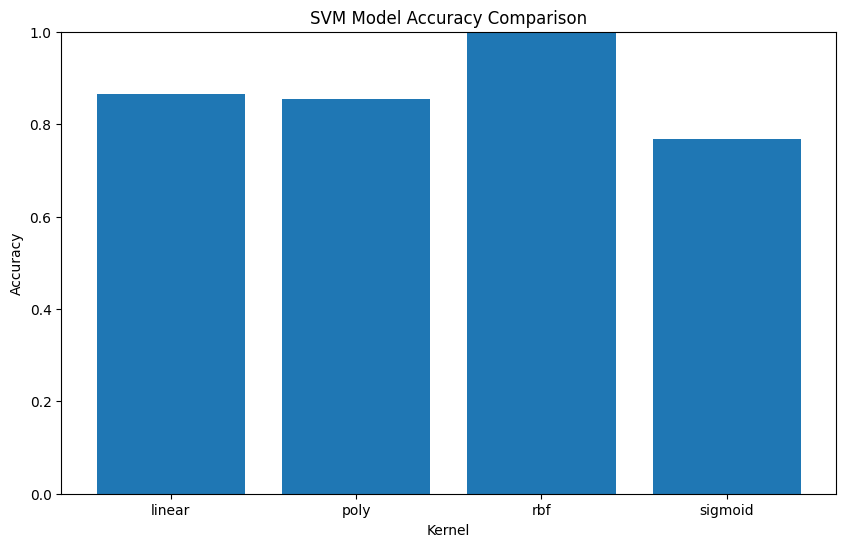

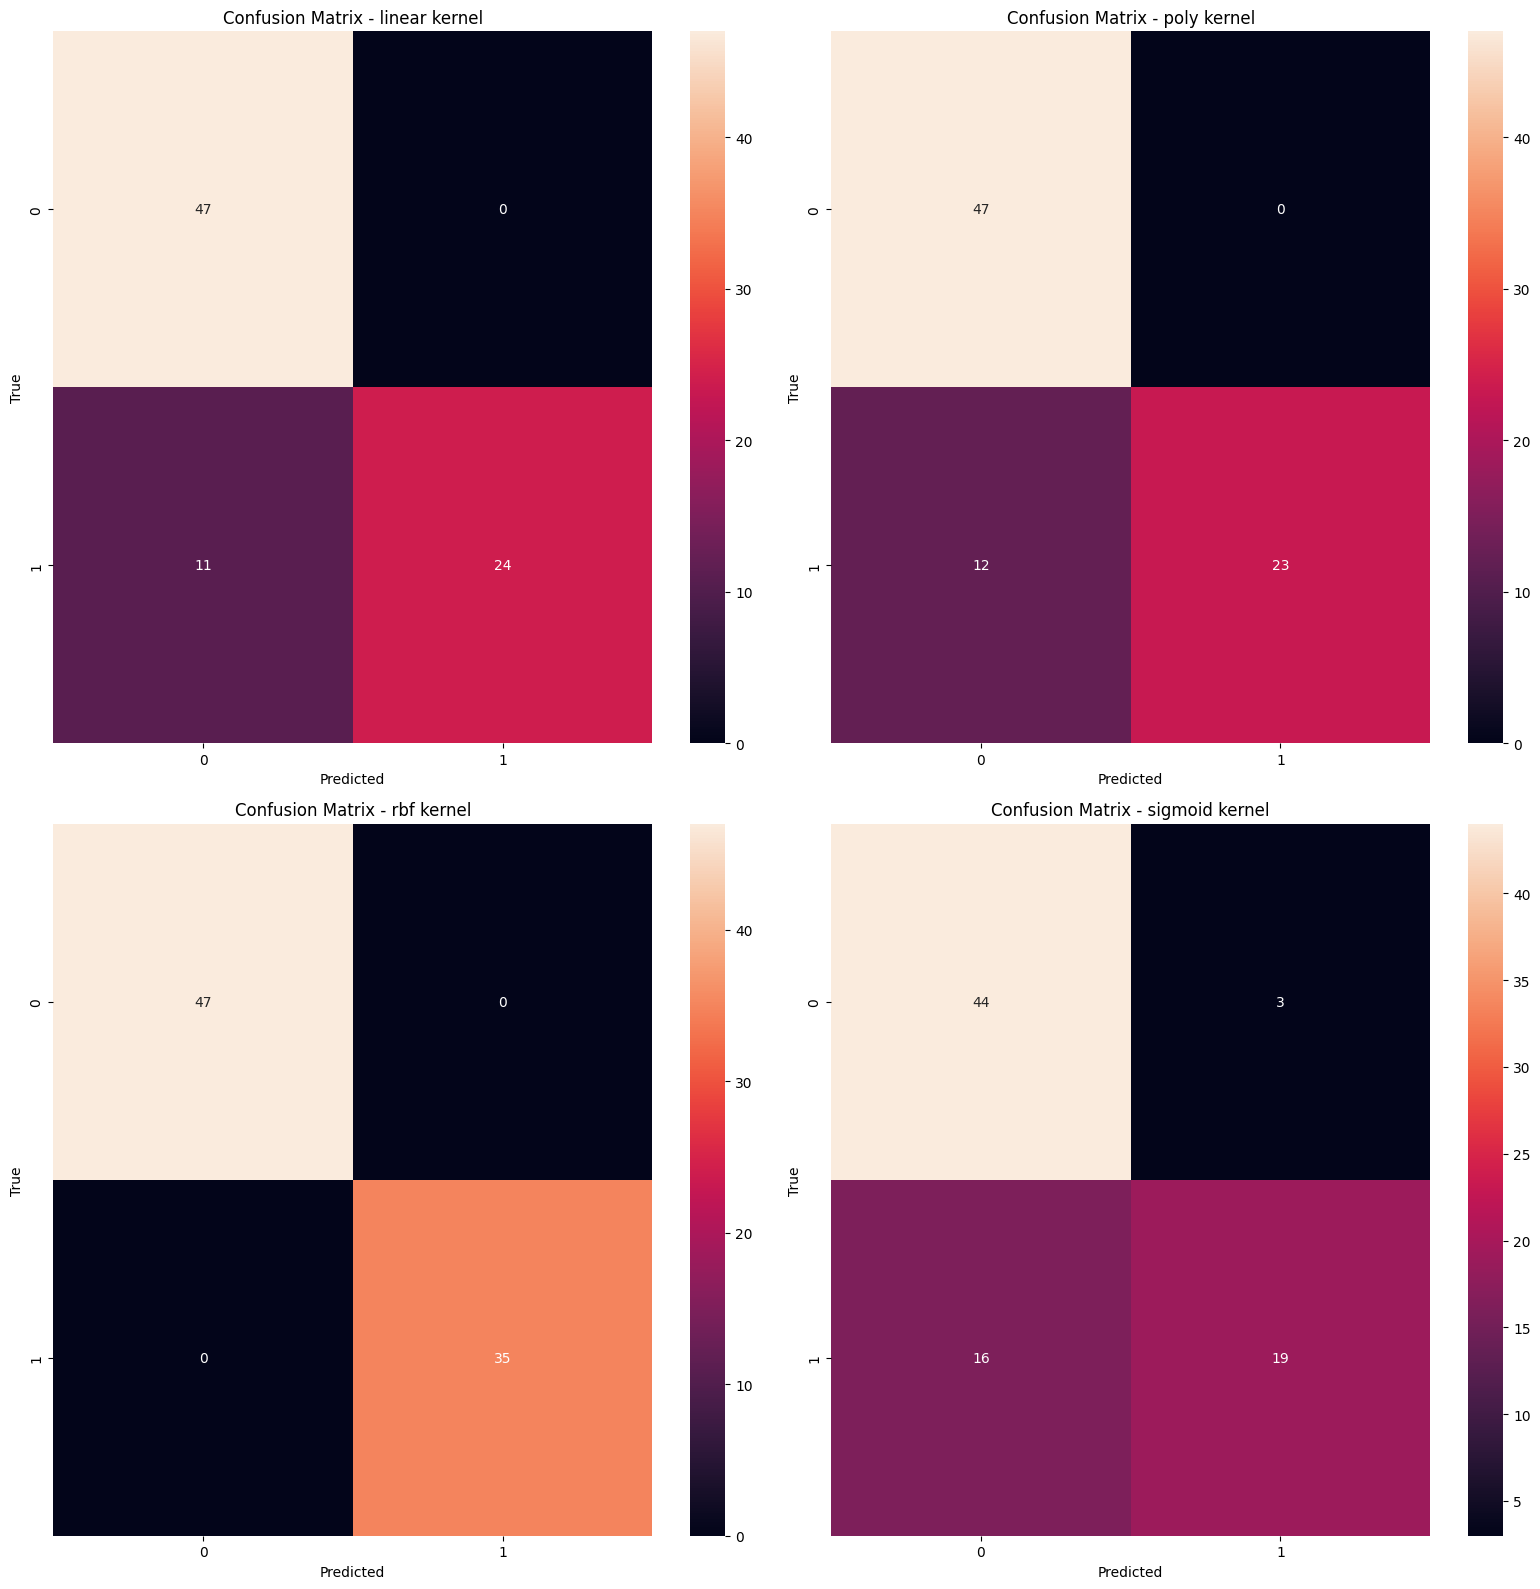

In [170]:
plt.figure(figsize=(10, 6))
accuracies = [results[kernel]['accuracy'] for kernel in kernels]
plt.bar(kernels, accuracies)
plt.title('SVM Model Accuracy Comparison')
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.ravel()

for i, (kernel, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['model'].predict(X_test))
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {kernel} kernel')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()

In [172]:
best_kernel = max(results, key=lambda k: results[k]['accuracy'])
best_model = results[best_kernel]['model']

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': [best_kernel]
}
svc = SVC(probability=True)
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = best_model.score(X_test, y_test)
report = classification_report(y_test, y_pred)

print(f"\nBest model results (after tuning):")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Best parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Best cross-validation score: 0.9876923076923078

Best model results (after tuning):
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        47
         1.0       1.00      1.00      1.00        35

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



In [173]:
print("Probability enabled after training:", best_model.probability)

Probability enabled after training: True


In [174]:
import joblib

joblib.dump(best_model, 'D:\\Thesis\\Example_accelerometer\\svc_model.joblib')

['D:\\Thesis\\Example_accelerometer\\svc_model.joblib']

In [187]:
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter
from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes
)
print("done")
import onnx
import onnxruntime as ort
import numpy as np

done


In [229]:
model_svc_file = 'D:\\Thesis\\Example_accelerometer\\svc_model.joblib'
model_svc = joblib.load(model_svc_file)

print("Probability enabled:", model_svc.probability) 

Probability enabled: True


In [222]:
# label 0
testingexample = [0.016393442622951, -0.12280701754386, 0.0187265917603, 0.010928961748634, -0.263157894736842, -0.0187265917603,
     0.027322404371585, -0.105263157894737, -0.0187265917603, -0.038251366120219, -0.105263157894737, 0.0187265917603,
     -0.054644808743169, -0.114035087719298, -0.01123595505618, 0.027322404371585, -0.087719298245614, 0.0187265917603,
     0.027322404371585, -0.271929824561403, 0.013732833957553, 0.027322404371585, -0.114035087719298, 0.016229712858926,
     0.021857923497268, -0.105263157894737, -0.016229712858926, -0.049180327868853, -0.271929824561403, -0.016229712858926]

In [208]:
# label 1
testingexample = [0.191256830601093, -0.087719298245614, -0.136079900124844,
                      0.273224043715847, 0.166666666666667, -0.00374531835206,
                      0.147540983606557, -0.06140350877193, 0.013732833957553,
                      -0.136612021857924, -0.263157894736842, 0.223470661672909,
                      -0.054644808743169, -0.219298245614035, 0.403245942571785,
                      0.060109289617486, -0.18421052631579, 0.3458177278402,
                      0.300546448087432, 0.105263157894737, 0.343320848938826,
                      0.344262295081967, 0.12280701754386, 0.243445692883895,
                      0.26775956284153, 0.219298245614035, 0.028714107365793,
                      0.14207650273224, 0.166666666666667, -0.021223470661673]

In [242]:
# label 1
testingexample = [
    0.431693989071038, -0.535087719298246, 0.51310861423221,
    0.131147540983606, -0.307017543859649, 0.243445692883895,
    0.038251366120219, -0.12280701754386, 0.056179775280899,
    -0.120218579234973, -0.131578947368421, 0.036204744069913,
    -0.229508196721311, -0.070175438596491, 0.001248439450687,
    -0.420765027322404, 0.052631578947368, 0.056179775280899,
    -0.442622950819672, 0.008771929824561, -0.076154806491885,
    -0.355191256830601, 0.087719298245614, -0.255930087390761,
    -0.40983606557377, 0.114035087719298, -0.273408239700375,
    -0.469945355191257, 0.464912280701754, -0.285892634207241
]

In [236]:
# label 0
testingexample = [
    0.016393442622951, -0.12280701754386, -0.0187265917603,
    0.027322404371585, -0.114035087719298, -0.0187265917603,
    0.016393442622951, -0.271929824561403, -0.013732833957553,
    0.021857923497268, -0.114035087719298, -0.006242197253433,
    0.010928961748634, -0.105263157894737, 0.046192259675406,
    0.010928961748634, -0.12280701754386, -0.0187265917603,
    0.016393442622951, -0.12280701754386, -0.0187265917603,
    0.021857923497268, -0.12280701754386, -0.0187265917603,
    -0.049180327868853, -0.096491228070175, 0.013732833957553,
    -0.005464480874317, -0.289473684210526, 0.013732833957553
]


In [243]:
features = np.array([testingexample]).astype(np.float32)

In [244]:
result1_1 = model_svc.predict(features)[0]
result1_2 = model_svc.predict_proba(features)[0]

In [245]:
print('svm1_file, SKLEARN result is %s, %s\n'%(str(result1_1), str(result1_2)))

svm1_file, SKLEARN result is 1.0, [0.00284318 0.99715682]



In [246]:
initial_types = [('float_input',FloatTensorType([None, 30]))]
onx1 = convert_sklearn(model_svc, initial_types = initial_types)
with open("svm_conv.onnx", "wb") as f:
        f.write(onx1.SerializeToString())


In [247]:
sess1 = rt.InferenceSession(onx1.SerializeToString())
res1 = sess1.run(None, {'float_input': features.astype(np.float32)})
print(res1)

[array([1], dtype=int64), [{0: 0.002843238413333893, 1: 0.9971568584442139}]]
